In [67]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import xarray as xr
import numpy as np

import matplotlib as mpl  
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# load nmc_met_io for retrieving micaps server data
import sys
print(sys.path)
sys.path.insert(0, "/home/x711/code/nmc_met_io") # .append("/home/x711/code/nmc_met_io")
print(sys.path)

from nmc_met_io.retrieve_cassandraDB  import *


xr.set_options(display_style="text")

['/home/x711/code/nmc_met_io', '/home/x711/code/nmc_met_io', '/home/x711/code/nmc_met_io', '/home/x711/code/nmc_met_io', '/home/x711/code/ec', '/home/x711/anaconda3/lib/python39.zip', '/home/x711/anaconda3/lib/python3.9', '/home/x711/anaconda3/lib/python3.9/lib-dynload', '', '/home/x711/anaconda3/lib/python3.9/site-packages']
['/home/x711/code/nmc_met_io', '/home/x711/code/nmc_met_io', '/home/x711/code/nmc_met_io', '/home/x711/code/nmc_met_io', '/home/x711/code/nmc_met_io', '/home/x711/code/ec', '/home/x711/anaconda3/lib/python39.zip', '/home/x711/anaconda3/lib/python3.9', '/home/x711/anaconda3/lib/python3.9/lib-dynload', '', '/home/x711/anaconda3/lib/python3.9/site-packages']


## 1.1 读取多个时次的模式预报数据 TEMP

In [69]:
%time
directory850 = "ECMWF_HR/WIND/850"
directory500 = "ECMWF_HR/WIND/500"
fhours = np.arange(0, 168, 24)
filenames = ['22062220.'+'%03d'%(fhour) for fhour in fhours]
Wind850 = get_model_grids(directory850, filenames, varname='WIND', varattrs={'long_name':'850hPa Wind', 'units':'m/s'}, cache=False)
Wind500 = get_model_grids(directory500, filenames, varname='WIND', varattrs={'long_name':'500hPa Wind', 'units':'m/s'}, cache=False)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.58 µs


In [70]:
Wind850

<xarray.Dataset>
Dimensions:                  (time: 7, level: 1, lat: 281, lon: 361)
Coordinates:
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
  * lat                      (lat) float64 -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * level                    (level) float32 850.0
  * time                     (time) datetime64[ns] 2022-06-22T20:00:00 ... 20...
    forecast_reference_time  datetime64[ns] 2022-06-22T20:00:00
    forecast_period          (time) float64 0.0 24.0 48.0 72.0 96.0 120.0 144.0
Data variables:
    speed                    (time, level, lat, lon) float32 8.289 ... 10.9
    angle                    (time, level, lat, lon) float32 138.9 ... 263.8
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB

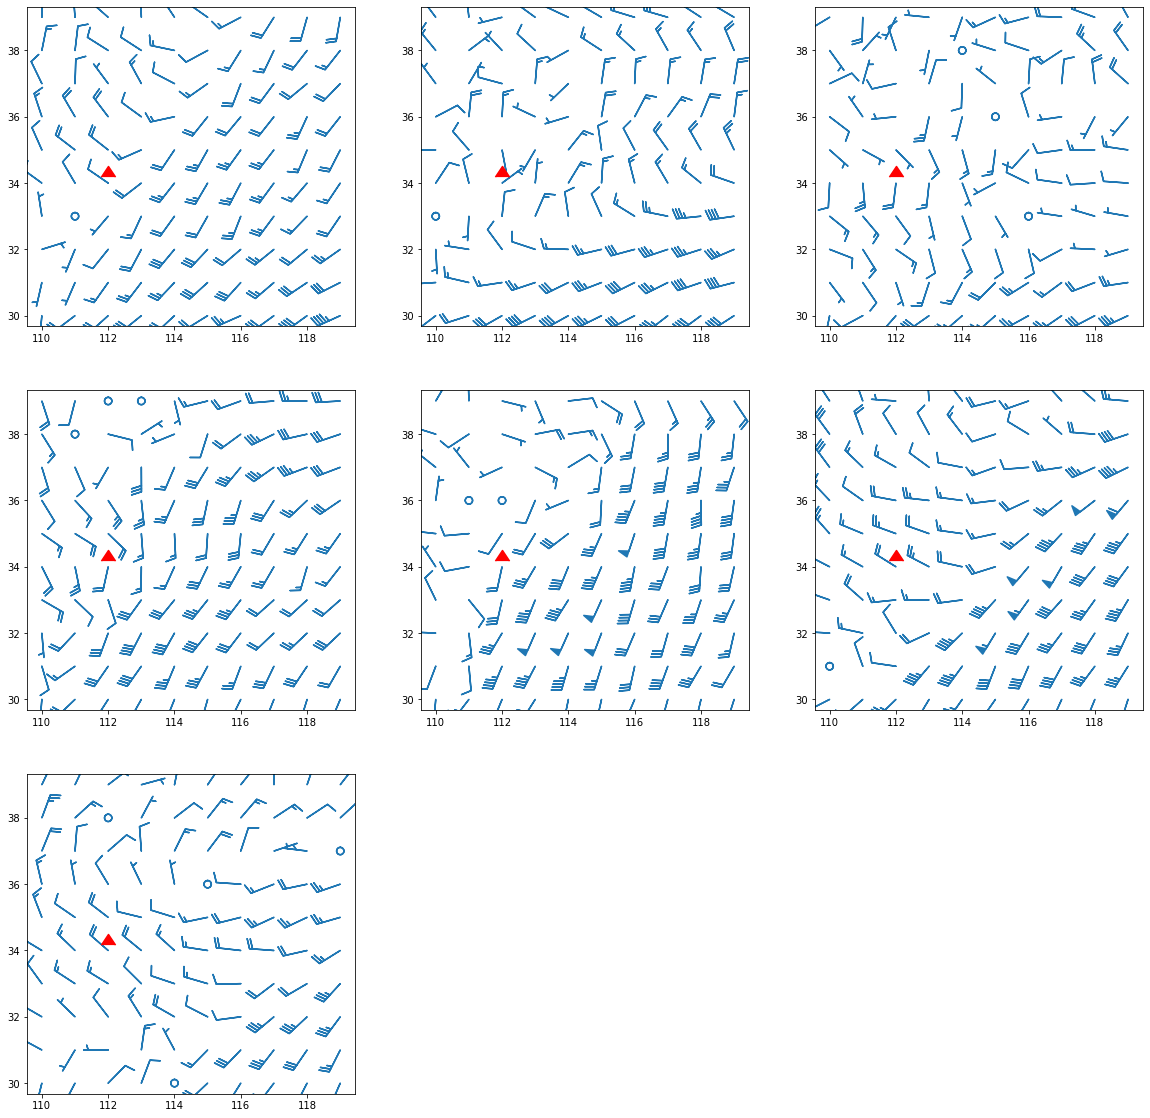

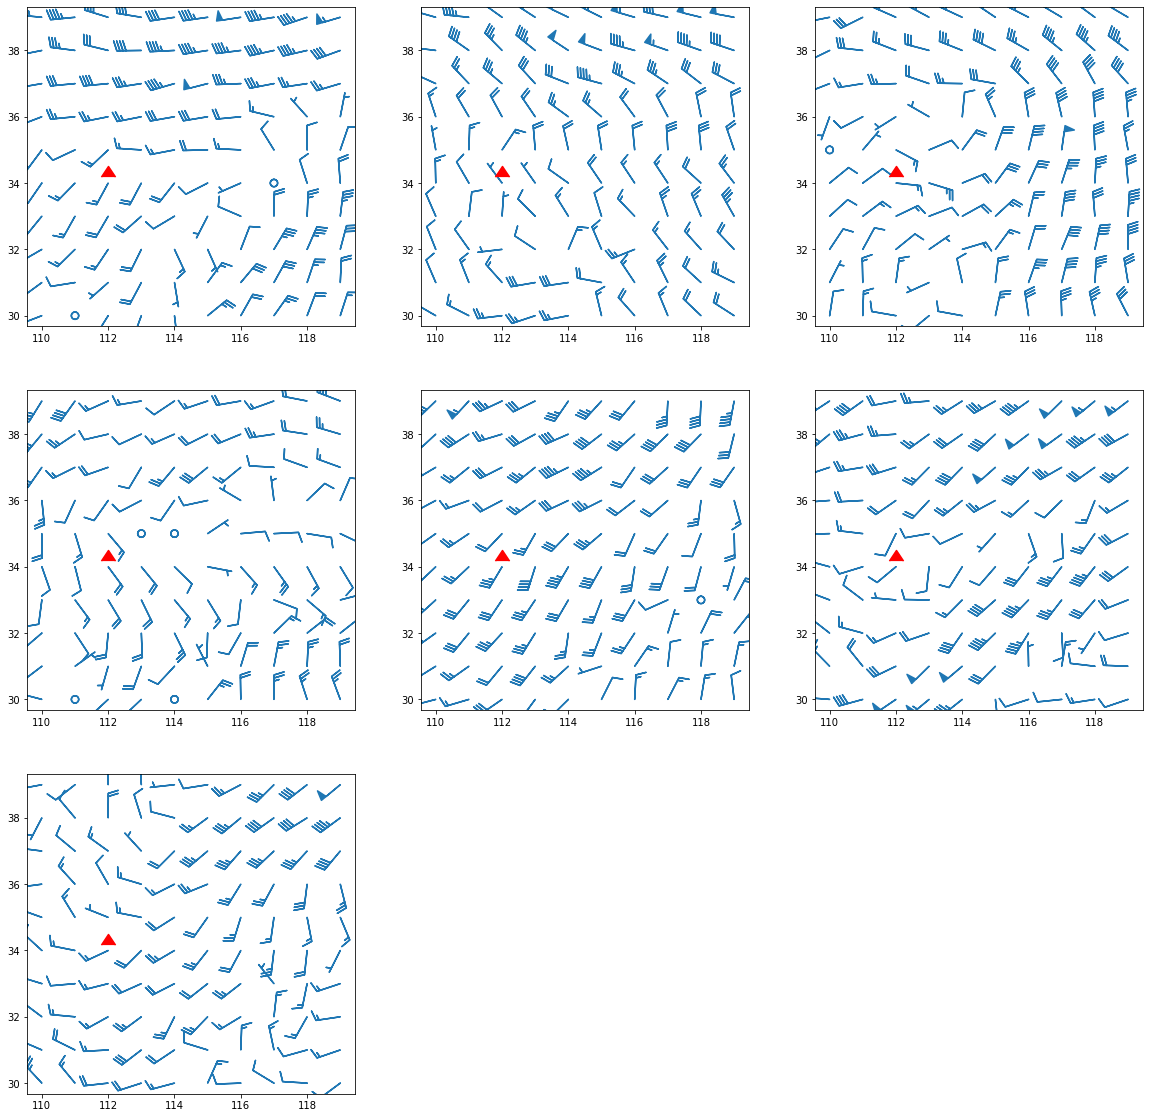

In [71]:
# 绘制图像
left = 110
right=120
top = 40
bottom = 30

Wind850 = Wind850.isel(level=0).sel(lon=np.arange(left,right,1),lat=np.arange(bottom,top,1), method="nearest")

fig = plt.figure(figsize=(20, 20))

index = 0
for row in range(0,100):
    for col in range(0, 3):
        if index >= Wind850.dims['time']:
            break

        latestEC = Wind850.isel(time=index)

        angle = (270 - latestEC.angle) * np.pi / 180

        ecU850 = latestEC.speed * np.cos(angle)
        ecV850 = latestEC.speed * np.sin(angle)

        index = index + 1
        ax = fig.add_subplot(3,3, index)

        ax.barbs(latestEC.lon, latestEC.lat, ecU850, ecV850, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
        ax.axis('equal')
        ax.scatter(112, 34.5, s=200, c='red', marker=6)


Wind500 = Wind500.isel(level=0).sel(lon=np.arange(left,right,1),lat=np.arange(bottom,top,1), method="nearest")

fig = plt.figure(figsize=(20, 20))

index = 0
for row in range(0,100):
    for col in range(0, 3):
        if index >= Wind500.dims['time']:
            break

        latestEC = Wind500.isel(time=index)

        angle = (270 - latestEC.angle) * np.pi / 180

        ecU500 = latestEC.speed * np.cos(angle)
        ecV500 = latestEC.speed * np.sin(angle)

        index = index + 1
        ax = fig.add_subplot(3,3, index)
        ax.barbs(latestEC.lon, latestEC.lat, ecU500 - ecU850, ecV500 - ecV850, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
        ax.axis('equal')
        ax.scatter(112, 34.5, s=200, c='red', marker=6)

        

## 1.2 High Wind Plot

In [72]:
level = '925'


In [73]:
plot850 = get_station_data(f"UPPER_AIR/PLOT/{level}", "20220624080000.000", dropna=True, cache=False)

plot850 = plot850.dropna(how='any')
plot850 = plot850[(bottom <= plot850['lat']) & (plot850['lat'] <= top) &
                    (left <= plot850['lon']) & (plot850['lon'] <= right)]
                    
plot850

,ID,lon,lat,Alt,Dewpoint_depression,Geopotential_hight,Temp,Wind_angle,Wind_speed,time
10,53798,114.360001,37.180000,184.199997,19.700001,69.400002,29.200001,354.0,8.4,2022-06-24 08:00:00
20,58424,116.970001,30.620001,63.200001,4.700000,71.400002,24.500000,217.0,13.2,2022-06-24 08:00:00
55,57461,111.360001,30.740000,257.700012,7.300000,71.300003,25.100000,314.0,3.3,2022-06-24 08:00:00
73,57494,114.050003,30.600000,23.600000,1.700000,71.400002,23.400000,237.0,12.6,2022-06-24 08:00:00
84,58027,117.160004,34.290001,42.400002,9.700000,70.099998,26.299999,271.0,5.8,2022-06-24 08:00:00
115,57067,111.070000,34.080002,659.700012,9.600000,71.900002,20.900000,250.0,2.2,2022-06-24 08:00:00
118,54511,116.470001,39.810001,34.000000,18.400000,68.099998,25.100000,338.0,7.3,2022-06-24 08:00:00
125,57083,113.660004,34.709999,112.000000,14.800000,69.400002,30.799999,285.0,8.2,2022-06-24 08:00:00
138,54539,118.889999,39.430000,9.700000,15.500000,66.699997,23.799999,350.0,10.0,2022-06-24 08:00:00
178,57178,112.489998,33.099998,181.800003,3.900000,70.500000,25.600000,266.0,6.8,2022-06-24 08:00:00


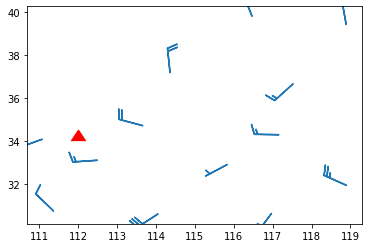

In [74]:
# plot:
angle = (270 - plot850.Wind_angle) * np.pi / 180

U = plot850.Wind_speed * np.cos(angle)
V = plot850.Wind_speed * np.sin(angle)

# plot:
fig, ax = plt.subplots()

wb = ax.barbs(plot850.lon, plot850.lat, U, V, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)

# ax.set(xlim=(0, 4.5), ylim=(0, 4.5))


ax.scatter(112, 34.5, s=200, c='red', marker=6)

# fig.colorbar(wb, ax=ax)

In [75]:
plot850[plot850['ID']==57083]
plot850

,ID,lon,lat,Alt,Dewpoint_depression,Geopotential_hight,Temp,Wind_angle,Wind_speed,time
10,53798,114.360001,37.180000,184.199997,19.700001,69.400002,29.200001,354.0,8.4,2022-06-24 08:00:00
20,58424,116.970001,30.620001,63.200001,4.700000,71.400002,24.500000,217.0,13.2,2022-06-24 08:00:00
55,57461,111.360001,30.740000,257.700012,7.300000,71.300003,25.100000,314.0,3.3,2022-06-24 08:00:00
73,57494,114.050003,30.600000,23.600000,1.700000,71.400002,23.400000,237.0,12.6,2022-06-24 08:00:00
84,58027,117.160004,34.290001,42.400002,9.700000,70.099998,26.299999,271.0,5.8,2022-06-24 08:00:00
115,57067,111.070000,34.080002,659.700012,9.600000,71.900002,20.900000,250.0,2.2,2022-06-24 08:00:00
118,54511,116.470001,39.810001,34.000000,18.400000,68.099998,25.100000,338.0,7.3,2022-06-24 08:00:00
125,57083,113.660004,34.709999,112.000000,14.800000,69.400002,30.799999,285.0,8.2,2022-06-24 08:00:00
138,54539,118.889999,39.430000,9.700000,15.500000,66.699997,23.799999,350.0,10.0,2022-06-24 08:00:00
178,57178,112.489998,33.099998,181.800003,3.900000,70.500000,25.600000,266.0,6.8,2022-06-24 08:00:00


## 1.3 Draw Wind Diff

In [76]:
dti = pd.date_range("2022-06-23 20:00", periods=6, freq="-12H").to_series()

filenames = dti.dt.strftime("%y%m%d%H")


directory850 = f"ECMWF_HR/WIND/{level}"
fhours = np.arange(12, 12*7, 12)
filenames = filenames + '.' + ['%03d'%(fhour) for fhour in fhours]

print(filenames)

Wind850 = get_model_grids(directory850, filenames, varname='WIND', varattrs={'long_name':'850hPa Wind', 'units':'m/s'}, cache=False)

Wind850

2022-06-23 20:00:00    22062320.012
2022-06-23 08:00:00    22062308.024
2022-06-22 20:00:00    22062220.036
2022-06-22 08:00:00    22062208.048
2022-06-21 20:00:00    22062120.060
2022-06-21 08:00:00    22062108.072
Freq: -12H, dtype: object


<xarray.Dataset>
Dimensions:                  (time: 6, level: 1, lat: 281, lon: 361)
Coordinates:
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
  * lat                      (lat) float64 -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * level                    (level) float32 925.0
  * time                     (time) datetime64[ns] 2022-06-24T08:00:00 ... 20...
    forecast_reference_time  (time) datetime64[ns] 2022-06-23T20:00:00 ... 20...
    forecast_period          (time) float64 12.0 24.0 36.0 48.0 60.0 72.0
Data variables:
    speed                    (time, level, lat, lon) float32 10.36 ... 2.82
    angle                    (time, level, lat, lon) float32 136.4 ... 237.5
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra DB

/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/x711/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will rai

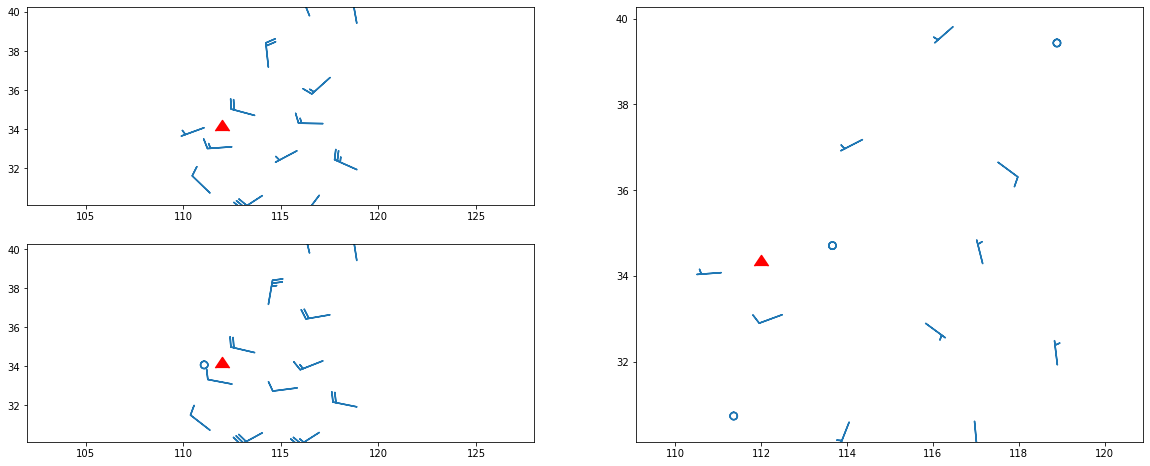

In [77]:
latestEC = Wind850.isel(time=0).isel(level=0)

angle = (270 - latestEC.angle) * np.pi / 180

ecU = latestEC.speed * np.cos(angle)
ecV = latestEC.speed * np.sin(angle)

#print(ecU.interp(lon=112,lat=34.5).item())

interpU = []
interpV = []
for index in range(0, plot850.shape[0]):
    item = plot850[index:index+1]
    interpU.append(ecU.interp(lon=item.lon,lat=item.lat).item())
    interpV.append(ecV.interp(lon=item.lon,lat=item.lat).item())

#print(U - interpU)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.barbs(plot850.lon, plot850.lat, U, V, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
ax0.axis('equal')

ax1 = fig.add_subplot(gs[1, 0])
ax1.barbs(plot850.lon, plot850.lat, interpU, interpV, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
ax1.axis('equal')

ax2 = fig.add_subplot(gs[:, 1])
wb = ax2.barbs(plot850.lon, plot850.lat, U - interpU, V - interpV, barb_increments={'half':2, 'full':4, 'flag':20}, barbcolor='C0', flagcolor='C0', length=7, linewidth=1.5)
# ax.set(xlim=(0, 4.5), ylim=(0, 4.5))
ax2.axis('equal')

ax0.scatter(112, 34.5, s=200, c='red', marker=6)
ax1.scatter(112, 34.5, s=200, c='red', marker=6)
ax2.scatter(112, 34.5, s=200, c='red', marker=6)

# fig.colorbar(wb, ax=ax)